In [3]:
import pandas as pd
import datetime
import numpy as np
import torch
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Concatenate, Add, Masking, GRU, RepeatVector, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MAE, MSE, RootMeanSquaredError


In [6]:
#import csv
merged_df = pd.read_csv('merged_treated_2000.csv', index_col=0)

#add key for DB later
merged_df['key'] = merged_df['name'] + '-' + merged_df['year'].astype('str') + '-' + merged_df['race_name']

#pd date time
merged_df['date'] = pd.to_datetime(merged_df['date'])

#split to predict later
merged_df_predict = merged_df[merged_df['year'] == 2022]
merged_df = merged_df[merged_df['year'] != 2022]

merged_df.shape

(317377, 27)

In [7]:
merged_df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num,key
0,egan-bernal,2020,etappe,2020-09-16,0,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,egan-bernal-2020-tour-de-france
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,andrey-amador-2020-tour-de-france
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,14962800.0,NaN,NaN,NaN,NaN,5.0,richard-carapaz-2020-tour-de-france
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,jonathan-castroviejo-2020-tour-de-france
4,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,michal-kwiatkowski-2020-tour-de-france


In [8]:
merged_df[merged_df['name'] == 'marcel-kittel']

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num,key
48791,marcel-kittel,2018,etappe,2018-07-18,0,NaN,stage,race/tour-de-france/2018/stage-11,tour-de-france,Stage 11 - Albertville › La Rosière Espace San...,...,4093.0,1702.0,0.4 km solo,0.0,NaN,NaN,NaN,NaN,5.0,marcel-kittel-2018-tour-de-france
48957,marcel-kittel,2018,etappe,2018-07-17,162,164.0,stage,race/tour-de-france/2018/stage-10,tour-de-france,Stage 10 - Annecy › Le Grand-Bornand,...,4254.0,1702.0,29.4 km solo,0.0,NaN,NaN,NaN,NaN,4.0,marcel-kittel-2018-tour-de-france
49126,marcel-kittel,2018,etappe,2018-07-15,124,165.0,stage,race/tour-de-france/2018/stage-9,tour-de-france,Stage 9 - Arras Citadelle › Roubaix,...,618.0,1702.0,Sprint of small group,0.0,NaN,NaN,NaN,NaN,1.0,marcel-kittel-2018-tour-de-france
49296,marcel-kittel,2018,etappe,2018-07-14,15,168.0,stage,race/tour-de-france/2018/stage-8,tour-de-france,Stage 8 - Dreux › Amiens Métropole,...,1284.0,1702.0,Sprint of large group,347208.0,NaN,NaN,NaN,NaN,1.0,marcel-kittel-2018-tour-de-france
49466,marcel-kittel,2018,etappe,2018-07-13,118,169.0,stage,race/tour-de-france/2018/stage-7,tour-de-france,Stage 7 - Fougères › Chartres,...,2255.0,1702.0,Sprint of large group,0.0,NaN,NaN,NaN,NaN,1.0,marcel-kittel-2018-tour-de-france
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345783,marcel-kittel,2011,etappe,2011-08-23,180,170.0,stage,race/vuelta-a-espana/2011/stage-4,vuelta-a-espana,Stage 4 - Baza › Sierra Nevada,...,3687.0,1120.0,Sprint a deux,0.0,NaN,NaN,NaN,NaN,5.0,marcel-kittel-2011-vuelta-a-espana
345980,marcel-kittel,2011,etappe,2011-08-22,178,149.0,stage,race/vuelta-a-espana/2011/stage-3,vuelta-a-espana,Stage 3 - Petrer › Totana,...,1956.0,1120.0,13 km solo,0.0,NaN,NaN,NaN,NaN,2.0,marcel-kittel-2011-vuelta-a-espana
346178,marcel-kittel,2011,etappe,2011-08-21,3,12.0,stage,race/vuelta-a-espana/2011/stage-2,vuelta-a-espana,Stage 2 - La Nucía › Playas de Orihuela,...,1305.0,1120.0,Sprint of large group,1209600.0,NaN,NaN,NaN,NaN,1.0,marcel-kittel-2011-vuelta-a-espana
346376,marcel-kittel,2011,etappe,2011-08-20,7,43.0,chrono,race/vuelta-a-espana/2011/stage-1,vuelta-a-espana,Stage 1 (TTT) - Benidorm › Benidorm,...,154.0,1120.0,Time Trial,376320.0,NaN,NaN,NaN,NaN,1.0,marcel-kittel-2011-vuelta-a-espana


In [358]:
merged_df = pd.read_csv('merged_treated_tdfincl.csv', index_col=0)
merged_df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,ProfileScore:,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num
0,egan-bernal,2020,etappe,2020-09-16,0,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,14962800.0,NaN,NaN,NaN,NaN,5.0
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0
4,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,444.0,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0


In [359]:
merged_df['key'] = merged_df['name'] + '-' + merged_df['year'].astype('str') + '-' + merged_df['race_name']
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df_predict = merged_df[merged_df['year'] == 2022]
merged_df = merged_df[merged_df['year'] != 2022]
merged_df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num,key
0,egan-bernal,2020,etappe,2020-09-16,0,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,egan-bernal-2020-tour-de-france
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,andrey-amador-2020-tour-de-france
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,14962800.0,NaN,NaN,NaN,NaN,5.0,richard-carapaz-2020-tour-de-france
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,jonathan-castroviejo-2020-tour-de-france
4,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,4430.0,1685.0,3.5 km solo,0.0,NaN,NaN,NaN,NaN,5.0,michal-kwiatkowski-2020-tour-de-france


In [345]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

minmax_features = MinMaxScaler()

minmax_features.fit(merged_df[['distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']])

merged_df[['distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']] = minmax_features.transform(merged_df[['distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']])

minmax_target= MinMaxScaler()

minmax_target.fit(merged_df[['result']])

merged_df[['result']] = minmax_target.transform(merged_df[['result']])

merged_df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num,key
0,egan-bernal,2020,etappe,2020-09-16,0.000000,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,0.0,NaN,NaN,NaN,NaN,1.0,egan-bernal-2020-tour-de-france
1,andrey-amador,2020,etappe,2020-09-16,0.116302,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,0.0,NaN,NaN,NaN,NaN,1.0,andrey-amador-2020-tour-de-france
2,richard-carapaz,2020,etappe,2020-09-16,0.010934,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,14962800.0,NaN,NaN,NaN,NaN,1.0,richard-carapaz-2020-tour-de-france
3,jonathan-castroviejo,2020,etappe,2020-09-16,0.115308,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,0.0,NaN,NaN,NaN,NaN,1.0,jonathan-castroviejo-2020-tour-de-france
4,michal-kwiatkowski,2020,etappe,2020-09-16,0.129225,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,0.638421,0.929912,3.5 km solo,0.0,NaN,NaN,NaN,NaN,1.0,michal-kwiatkowski-2020-tour-de-france


In [324]:
merged_df_predict[['distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']] = minmax_features.transform(merged_df_predict[['distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']])
merged_df_predict[['result']] = minmax_target.transform(merged_df_predict[['result']])
merged_df_predict.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,Vert. meters:,Startlist quality score:,Won how:,adjusted_points,Race category:,Points scale:,Arrival:,Won how:,parcours_type_num,key
249474,tadej-pogacar,2022,etappe,2022-07-15,0.011928,2.0,stage,race/tour-de-france/2022/stage-13,tour-de-france,Stage 13 - Bourg d'Oisans › Saint-Etienne,...,0.303934,0.855408,Sprint of small group,2176200.0,NaN,NaN,NaN,NaN,0.25,tadej-pogacar-2022-tour-de-france
249475,mikkel-bjerg,2022,etappe,2022-07-15,0.123260,155.0,stage,race/tour-de-france/2022/stage-13,tour-de-france,Stage 13 - Bourg d'Oisans › Saint-Etienne,...,0.303934,0.855408,Sprint of small group,0.0,NaN,NaN,NaN,NaN,0.25,mikkel-bjerg-2022-tour-de-france
249476,rafal-majka,2022,etappe,2022-07-15,0.064612,19.0,stage,race/tour-de-france/2022/stage-13,tour-de-france,Stage 13 - Bourg d'Oisans › Saint-Etienne,...,0.303934,0.855408,Sprint of small group,0.0,NaN,NaN,NaN,NaN,0.25,rafal-majka-2022-tour-de-france
249477,brandon-mcnulty,2022,etappe,2022-07-15,0.077535,30.0,stage,race/tour-de-france/2022/stage-13,tour-de-france,Stage 13 - Bourg d'Oisans › Saint-Etienne,...,0.303934,0.855408,Sprint of small group,0.0,NaN,NaN,NaN,NaN,0.25,brandon-mcnulty-2022-tour-de-france
249478,marc-soler,2022,etappe,2022-07-15,0.103380,64.0,stage,race/tour-de-france/2022/stage-13,tour-de-france,Stage 13 - Bourg d'Oisans › Saint-Etienne,...,0.303934,0.855408,Sprint of small group,0.0,NaN,NaN,NaN,NaN,0.25,marc-soler-2022-tour-de-france


In [546]:
merged_df['Avg. speed winner:']

0         35.28
1         35.28
2         35.28
3         35.28
4         35.28
          ...  
380923    55.32
380924    55.32
380925    55.32
380926    55.32
380927    55.32
Name: Avg. speed winner:, Length: 244469, dtype: float64

In [360]:
riders_predict = merged_df_predict[(merged_df_predict['race_name']=='tour-de-france')| (merged_df_predict['race_name']=='vuelta-a-espana')| (merged_df_predict['race_name']=='giro-d-italia')][['name', 'year', 'race_name']]
riders_predict = riders_predict[riders_predict['year'] == 2022].drop_duplicates().reset_index(drop=True)
riders_predict

,name,year,race_name
0,tadej-pogacar,2022,tour-de-france
1,mikkel-bjerg,2022,tour-de-france
2,rafal-majka,2022,tour-de-france
3,brandon-mcnulty,2022,tour-de-france
4,marc-soler,2022,tour-de-france
...,...,...,...
347,sergio-samitier,2022,giro-d-italia
348,filippo-fiorelli,2022,giro-d-italia
349,jakub-mareczko,2022,giro-d-italia
350,miguel-angel-lopez,2022,giro-d-italia


In [361]:
riders = merged_df[(merged_df['race_name']=='tour-de-france')| (merged_df['race_name']=='vuelta-a-espana')| (merged_df['race_name']=='giro-d-italia')][['name', 'year', 'race_name']]
riders = riders[riders['year'] != 2022].drop_duplicates().reset_index(drop=True)
riders

,name,year,race_name
0,egan-bernal,2020,tour-de-france
1,andrey-amador,2020,tour-de-france
2,richard-carapaz,2020,tour-de-france
3,jonathan-castroviejo,2020,tour-de-france
4,michal-kwiatkowski,2020,tour-de-france
...,...,...,...
6528,bernhard-eisel,2010,vuelta-a-espana
6529,john-lee-augustyn,2010,vuelta-a-espana
6530,ben-swift,2010,vuelta-a-espana
6531,mickael-buffaz,2010,vuelta-a-espana


In [550]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(riders, test_size=0.2, random_state=42)

In [776]:
def get_sequence(df, name, year, tour, weeks=104):
    
    #get tour data
    if year != 2010:
        tour_data = df[(df['name'] == name) & (df['year'] == year) & (df['race_name'] == tour)].sort_values(by='date')
        y_decoder = tour_data[['date', 'result']].set_index('date')
        X_decoder = tour_data[['date', 'distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']].set_index('date')
        
        season_data = df[(df['name'] == name) & (df['date'] < min(tour_data['date'])) & (df['date'] >= min(tour_data['date']) - datetime.timedelta(weeks=weeks))].sort_values(by='date')
        X_encoder = season_data[['date', 'distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']].set_index('date')
        y_encoder = season_data[['date', 'result']].set_index('date')
        
    return X_encoder, X_decoder, y_decoder, y_encoder

In [780]:
def get_scaler(maxlen, df, riders):
    
    X_encoder_ls = []
    X_decoder_ls = []
    #y_ls = []


    for rider, year, tour in riders.values:
        
        if year != 2010:
            
            X_encoder, X_decoder, y_decoder, y_encoder = get_sequence(df, rider, year, tour)
            
            X_encoder_ls.append(X_encoder)
            X_decoder_ls.append(X_decoder)
            #y_ls.append(y)
            
    X_encoder_scdf = pd.concat(X_encoder_ls)
    X_decoder_scdf = pd.concat(X_decoder_ls)
    #y_train_scdf = pd.concat(y_ls)
    
    X_enc_mm = MinMaxScaler()
    X_enc_mm.fit(X_encoder_scdf)
    
    X_dec_mm = MinMaxScaler()
    X_dec_mm.fit(X_decoder_scdf)
    
    #y_train_mm = MinMaxScaler()
    #y_train_mm.fit(y_train_scdf)

            
    return X_enc_mm, X_dec_mm#, y_train_mm

X_enc_mm, X_dec_mm = get_scaler(100, merged_df, train)

In [781]:
from keras.preprocessing.sequence import pad_sequences

def get_sequences(maxlen, df, riders):
    
    X_encoder_ls = []
    X_decoder_ls = []
    y_encoder_ls = []
    y_decoder_ls = []
    
    i=0


    for rider, year, tour in riders.values:
        
        if year != 2010:
            
            #print(rider, year, tour)
            
            try:
            
                #X_encoder, X_decoder, y = get_sequence(df, rider, year, tour)
                X_encoder, X_decoder, y_decoder, y_encoder = get_sequence(df, rider, year, tour)
                
                X_encoder = X_enc_mm.transform(X_encoder)
                X_decoder = X_dec_mm.transform(X_decoder)
                #y = y_train_mm.transform(y)
                
                X_encoder_pad = pad_sequences(X_encoder.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                y_encoder_pad = pad_sequences(y_encoder.to_numpy().T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                
                X_decoder_pad = pad_sequences(X_decoder.T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                y_decoder_pad = pad_sequences(y_decoder.to_numpy().T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                #X_decoder_pad = pad_sequences(X_decoder_pad.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                
                #y_decoder_pad = pad_sequences(y_decoder.T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                #y_pad = pad_sequences(y_decoder_pad.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                    
                X_encoder_ls.append(X_encoder_pad)
                X_decoder_ls.append(X_decoder_pad)
                y_encoder_ls.append(y_encoder_pad)
                y_decoder_ls.append(y_decoder_pad)
                #y_ls.append(y_pad)
                
                #print(X_encoder_pad.shape, X_decoder_pad.shape, y_pad.shape)
            
            except ValueError:
                i+=1
                print(f"ValueError for {i, rider, year, tour}")
    
    return np.array(X_encoder_ls), np.array(X_decoder_ls), np.array(y_encoder_ls), np.array(y_decoder_ls)


In [782]:
X_encoder_train, X_decoder_train, y_encoder_train, y_decoder_train = get_sequences(100, merged_df, train)
X_encoder_test, X_decoder_test, y_encoder_test, y_decoder_test = get_sequences(100, merged_df, test)
X_encoder_predict, X_decoder_predict, y_encoder_predict, y_decoder_predict = get_sequences(100, merged_df_predict, riders_predict)

ValueError for (1, 'chris-barton', 2011, 'giro-d-italia')
ValueError for (2, 'jeremie-galland', 2011, 'tour-de-france')
ValueError for (3, 'victor-cabedo', 2012, 'giro-d-italia')
ValueError for (4, 'matti-breschel', 2011, 'vuelta-a-espana')
ValueError for (5, 'ramon-carretero', 2014, 'giro-d-italia')
ValueError for (6, 'jimmy-engoulvent', 2011, 'tour-de-france')
ValueError for (7, 'andreas-dietziker', 2012, 'giro-d-italia')
ValueError for (8, 'philip-deignan', 2014, 'giro-d-italia')
ValueError for (9, 'anthony-delaplace', 2011, 'tour-de-france')
ValueError for (10, 'cyril-dessel', 2011, 'giro-d-italia')
ValueError for (11, 'anthony-roux', 2011, 'tour-de-france')
ValueError for (12, 'andrey-mizurov', 2011, 'vuelta-a-espana')
ValueError for (13, 'antonio-cabello-baena', 2011, 'vuelta-a-espana')
ValueError for (14, 'david-bernabeu', 2011, 'vuelta-a-espana')
ValueError for (15, 'ruslan-pidgornyy', 2011, 'vuelta-a-espana')
ValueError for (16, 'gang-xu', 2015, 'giro-d-italia')
ValueError for

In [804]:

    

def encoder_2(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    #each LSTM unit returning a sequence of 5 outputs, one for each time step in the input data
    y = LSTM(units=5, return_sequences=True, activation='tanh')(y)
    #y = LSTM(units=3, return_sequences=True, activation='tanh')(y)
    #output one time step from the sequence for each time step in the input but process 5 outputs of the input sequence at a time
    #y = RepeatVector(1)
    y = TimeDistributed(Dense(units=1, activation='tanh'))(y)
    y = LSTM(units=5, return_sequences=False, activation='tanh')(y)
    y = RepeatVector(21)(y)
    #y = Dense(units=5)(y)
    return y

def decoder_2(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    y = TimeDistributed(Dense(units=5, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1, activation='linear'))(x)
    return y

In [783]:
def model70():
    input_70 = Input(shape=(X_encoder_train.shape[1:]))

    x =  Masking(mask_value = -1000.)(input_70)
    x = LSTM(units=100, return_sequences=True, activation='tanh')(x)
    x = LSTM(units=50, return_sequences=True, activation='tanh')(x)
    output = TimeDistributed(Dense(units=1, activation='linear'))(x)

    model_num = Model(inputs=input_70, outputs=output)
    
    return model_num

model_num = model70()
model_num.summary()

Model: "model_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_269 (InputLayer)      [(None, 100, 5)]          0         
                                                                 
 masking_204 (Masking)       (None, 100, 5)            0         
                                                                 
 lstm_303 (LSTM)             (None, 100, 100)          42400     
                                                                 
 lstm_304 (LSTM)             (None, 100, 50)           30200     
                                                                 
 time_distributed_154 (TimeD  (None, 100, 1)           51        
 istributed)                                                     
                                                                 
Total params: 72,651
Trainable params: 72,651
Non-trainable params: 0
______________________________________________________

In [784]:

es = EarlyStopping(patience=2)
metric = RootMeanSquaredError()


model_num.compile(loss = "mse", optimizer=Adam(learning_rate=4e-4), metrics=[metric])
model_num.fit(X_encoder_train, y_encoder_train, 
          validation_split=0.3,
          epochs=1000, 
          batch_size=64,
          callbacks=[es]
          )

Epoch 1/1000
53/53 [==============================] - 13s 152ms/step - loss: 4218.2920 - root_mean_squared_error: 80.4062 - val_loss: 3907.5940 - val_root_mean_squared_error: 77.2920
Epoch 2/1000
53/53 [==============================] - 6s 112ms/step - loss: 3758.9312 - root_mean_squared_error: 75.9021 - val_loss: 3706.8875 - val_root_mean_squared_error: 75.2808
Epoch 3/1000
53/53 [==============================] - 6s 111ms/step - loss: 3619.1140 - root_mean_squared_error: 74.4771 - val_loss: 3598.8210 - val_root_mean_squared_error: 74.1754
Epoch 4/1000
53/53 [==============================] - 6s 110ms/step - loss: 3521.2034 - root_mean_squared_error: 73.4627 - val_loss: 3508.6782 - val_root_mean_squared_error: 73.2405
Epoch 5/1000
53/53 [==============================] - 6s 111ms/step - loss: 3434.9824 - root_mean_squared_error: 72.5577 - val_loss: 3426.2024 - val_root_mean_squared_error: 72.3746
Epoch 6/1000
53/53 [==============================] - 6s 111ms/step - loss: 3355.0674 - r

KeyboardInterrupt: 

In [796]:
# define the encoder and decoder
def encoder_output70(x):
    x =  Masking(mask_value = -1000.)(x)
    x = LSTM(units=5, return_sequences=True, activation='tanh')(x)
    y = LSTM(units=1, return_sequences=True, activation='linear')(x)
    #y = TimeDistributed(Dense(units=1, activation='linear'))(y)
    return y, x

def decoder_output5(x):
    x =  Masking(mask_value = -1000.)(x)
    y = LSTM(units=10, return_sequences=True, activation='tanh')(x)
    y = LSTM(units=5, return_sequences=False, activation='tanh')(y)
    y = RepeatVector(21)(y)
    return y
    
def decoder_output21(dec5_output, decoder_features):
    #y = RepeatVector(21)(y)
    y = Concatenate(axis=-1)([decoder_features, dec5_output])
    print(y)
    y = LSTM(units=5, return_sequences=True, activation='linear')(y)
    y = LSTM(units=1, return_sequences=True, activation='linear')(y)
    #y = TimeDistributed(Dense(units=1, activation='linear'))
    return y

In [803]:
X_encoder_train.shape, X_decoder_train.shape, y_encoder_train.shape, y_decoder_train.shape

((4770, 100, 5), (4770, 21, 5), (4770, 100, 1), (4770, 21, 1))

In [802]:
# build the model
encoder_features = Input(shape=X_encoder_train.shape[1:])
decoder_features = Input(shape=X_decoder_train.shape[1:])


encoder_outputs, encoder_context = encoder_output70(encoder_features)

decoder_outputs = decoder_output5(encoder_context)

final_decoder_outputs = decoder_output21(decoder_outputs, decoder_features)

encoder_features, decoder_features, encoder_outputs, encoder_context, decoder_outputs, final_decoder_outputs

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 10), dtype=tf.float32, name=None), name='concatenate_90/concat:0', description="created by layer 'concatenate_90'")


(<KerasTensor: shape=(None, 100, 5) dtype=float32 (created by layer 'input_296')>,
 <KerasTensor: shape=(None, 21, 5) dtype=float32 (created by layer 'input_297')>,
 <KerasTensor: shape=(None, 100, 1) dtype=float32 (created by layer 'lstm_356')>,
 <KerasTensor: shape=(None, 100, 5) dtype=float32 (created by layer 'lstm_355')>,
 <KerasTensor: shape=(None, 21, 5) dtype=float32 (created by layer 'repeat_vector_59')>,
 <KerasTensor: shape=(None, 21, 1) dtype=float32 (created by layer 'lstm_360')>)

In [801]:
model = Model([encoder_features, decoder_features], [encoder_outputs, final_decoder_outputs])


In [ ]:
encoder_outputs, decoder_outputs, final_decoder_outputs

(<KerasTensor: shape=(None, 70, 1) dtype=float32 (created by layer 'lstm_255')>,
 <KerasTensor: shape=(None, 21, 5) dtype=float32 (created by layer 'repeat_vector_47')>,
 <KerasTensor: shape=(None, 21, 1) dtype=float32 (created by layer 'lstm_258')>)

In [737]:
# train the model
metric = RootMeanSquaredError()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=[metric])

es = EarlyStopping(verbose=1, patience=8, restore_best_weights=True)

model.fit([X_encoder_train, X_decoder_train], [y_encoder_train, y_decoder_train], epochs=10000, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/10000


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_absolute_error_1/sub/BroadcastGradientArgs' defined at (most recent call last):
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/3l/70h6qcrd72q0j5x4sscw7qn40000gn/T/ipykernel_87527/1651267372.py", line 8, in <cell line: 8>
      model.fit([X_encoder_train, X_decoder_train], [y_encoder_train, y_decoder_train], epochs=10000, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_absolute_error_1/sub/BroadcastGradientArgs'
Incompatible shapes: [256,21,1] vs. [128,21,1]
	 [[{{node gradient_tape/mean_absolute_error_1/sub/BroadcastGradientArgs}}]] [Op:__inference_train_function_1252483]

In [623]:
# build the model
encoder_features = Input(shape=X_encoder_train.shape[1:])
decoder_features = Input(shape=X_decoder_train.shape[1:])
encoder_outputs = encoder_2(encoder_features)
decoder_outputs = decoder_2(decoder_features, encoder_outputs)

#encoder_outputs = encoder_3(encoder_features)



model = Model([encoder_features, decoder_features], [encoder_outputs, decoder_outputs])

In [624]:
encoder_features, encoder_outputs, decoder_features, decoder_outputs

(<KerasTensor: shape=(None, 70, 5) dtype=float32 (created by layer 'input_162')>,
 <KerasTensor: shape=(None, 21, 5) dtype=float32 (created by layer 'repeat_vector_18')>,
 <KerasTensor: shape=(None, 21, 5) dtype=float32 (created by layer 'input_163')>,
 <KerasTensor: shape=(None, 21, 1) dtype=float32 (created by layer 'time_distributed_134')>)

In [542]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_134 (InputLayer)         [(None, 70, 5)]      0           []                               
                                                                                                  
 masking_87 (Masking)           (None, 70, 5)        0           ['input_134[0][0]']              
                                                                                                  
 lstm_77 (LSTM)                 (None, 70, 6)        288         ['masking_87[0][0]']             
                                                                                                  
 time_distributed_101 (TimeDist  (None, 70, 1)       7           ['lstm_77[0][0]']                
 ributed)                                                                                  

In [4]:
# define the encoder and decoder -> clean
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    #each LSTM unit returning a sequence of 6 outputs, one for each time step in the input data
    y = LSTM(units=6, return_sequences=True, activation='tanh')(y)
    #y = LSTM(units=3, return_sequences=True, activation='tanh')(y)
    #output one time step from the sequence for each time step in the input but process 5 outputs of the input sequence at a time
    y = TimeDistributed(Dense(units=6, activation='tanh'))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    print(x)
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    #y = TimeDistributed(Dense(units=6, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1, activation='linear'))(x)
    return y

In [5]:
# build the model -> clean
encoder_features = Input(shape=X_encoder_train.shape[1:])
decoder_features = Input(shape=X_decoder_train.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

NameError: name 'X_encoder_train' is not defined

In [583]:
# train the model
metric = RootMeanSquaredError()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=8, restore_best_weights=True)

model.fit([X_encoder_train, X_decoder_train], y_train, epochs=10000, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/10000


ValueError: in user code:

    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/michieldekoninck/.pyenv/versions/3.8.12/envs/boonen/lib/python3.8/site-packages/keras/losses.py", line 1457, in mean_absolute_error
        return backend.mean(tf.abs(y_pred - y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 21 and 70 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](model_29/repeat_vector_7/Tile, IteratorGetNext:2)' with input shapes: [?,21,5], [?,70,1].


In [458]:
model.evaluate([X_encoder_test, X_decoder_test], y_test)

38/38 [==============================] - 0s 4ms/step - loss: 0.0971 - root_mean_squared_error: 0.1983


[0.09712023288011551, 0.1983165442943573]

In [433]:
y_train_mm.inverse_transform([[0.1996]])

array([[200.7976]])

In [434]:
preds = model.predict([X_encoder_test, X_decoder_test])

In [435]:
preds[0].shape

(70, 1)

In [448]:
y_train_mm.inverse_transform(y_predict[0][-21:])

array([[  3.],
       [152.],
       [ 26.],
       [ 26.],
       [  7.],
       [  1.],
       [  1.],
       [  3.],
       [  5.],
       [ 20.],
       [  7.],
       [  5.],
       [ 12.],
       [ 23.],
       [ 12.],
       [ 16.],
       [  1.],
       [  2.],
       [  5.],
       [  3.],
       [ 20.]])

In [459]:
y_train_mm.inverse_transform(preds[0][-21:])

array([[-2.95178497e+02],
       [-3.22697266e+02],
       [-1.80093811e+02],
       [-7.33465424e+01],
       [-4.19611816e+02],
       [-3.12506287e+02],
       [-3.55444885e+02],
       [-2.04138000e+02],
       [-3.19582153e+02],
       [-4.97551880e+02],
       [-1.00610206e+06],
       [-1.00610400e+06],
       [-1.00609762e+06],
       [-1.00608700e+06],
       [-1.00607050e+06],
       [-1.00607794e+06],
       [-1.00609594e+06],
       [-1.00608756e+06],
       [-1.00610019e+06],
       [-1.00610256e+06],
       [-1.00607006e+06]], dtype=float32)

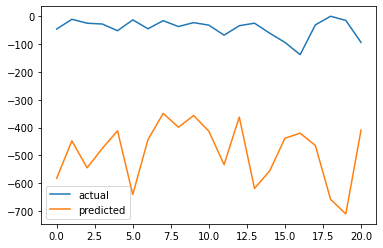

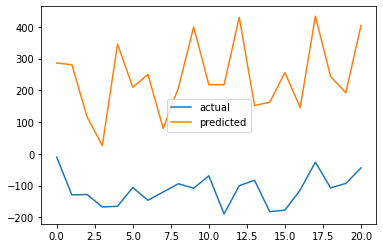

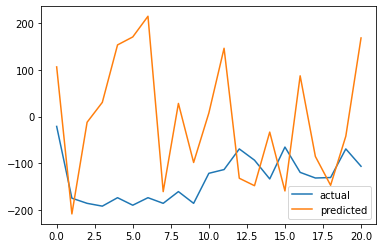

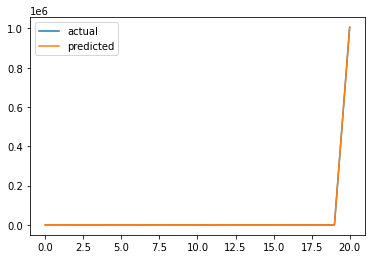

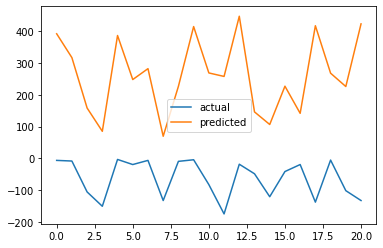

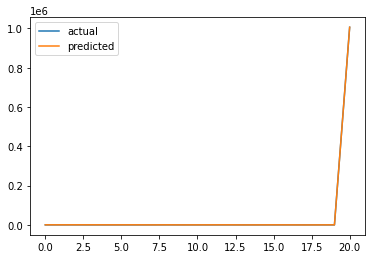

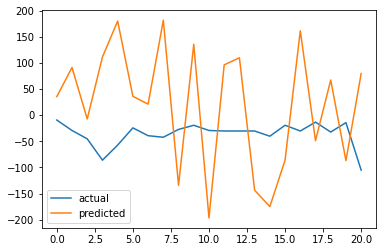

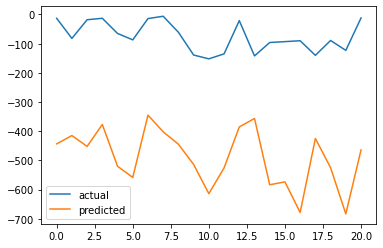

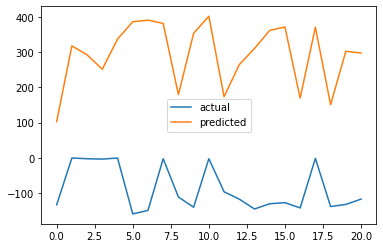

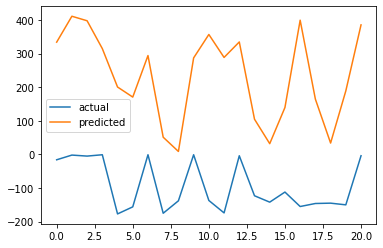

In [442]:
# extract the last predicted sequence
for seq in range(20,30):

    y_true = y_train_mm.inverse_transform(y_test[seq, :][-21:])*-1
    y_pred = y_train_mm.inverse_transform(model.predict([X_encoder_test, X_decoder_test])[seq, :][-21:])*-1

    # plot the last predicted sequence
    #plt.title(list(test_name)[seq])
    plt.plot(y_true.flatten(), label='actual')
    plt.plot(y_pred.flatten(), label='predicted')
    #plt.axis([0, 21, 0, -40])
    plt.legend()
    plt.show()

In [438]:
predict_2022 = model.predict([X_encoder_predict, X_decoder_predict])
predict_2022

array([[[-1.00000201e+03],
        [-1.00000201e+03],
        [-1.00000201e+03],
        ...,
        [ 4.06037271e-01],
        [ 4.83992696e-01],
        [ 2.60019898e-01]],

       [[-1.00000201e+03],
        [-1.00000201e+03],
        [-1.00000201e+03],
        ...,
        [ 4.19072449e-01],
        [ 4.63545799e-01],
        [ 2.42275015e-01]],

       [[-1.00000201e+03],
        [-1.00000201e+03],
        [-1.00000201e+03],
        ...,
        [-1.00008960e+03],
        [-1.00006342e+03],
        [-1.00006335e+03]],

       ...,

       [[-1.00000201e+03],
        [-1.00000201e+03],
        [-1.00000201e+03],
        ...,
        [-1.00004297e+03],
        [-1.00005542e+03],
        [-1.00004291e+03]],

       [[-1.00000201e+03],
        [-1.00000201e+03],
        [-1.00000201e+03],
        ...,
        [-1.00003326e+03],
        [-1.00001959e+03],
        [-1.00003784e+03]],

       [[-1.00000201e+03],
        [-1.00000201e+03],
        [-1.00000201e+03],
        ...,
        

In [443]:
ls_predict = []

for i in range(len(predict_2022)):
    ls_predict.append(np.append(y_train_mm.inverse_transform(predict_2022[i][-21:]).T, riders_predict.iloc[i].values))

In [808]:
predict_df = pd.DataFrame(ls_predict)
predict_df.head(30)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,310.899994,223.014130,207.719727,211.448090,257.473083,383.119659,546.729309,351.797272,267.178528,540.639404,...,239.030411,3.801602e+02,4.710342e+02,4.229324e+02,4.084735e+02,4.868966e+02,2.615800e+02,tadej-pogacar,2022,tour-de-france
1,287.848419,253.903412,232.100693,218.701096,255.865433,361.853607,548.846436,358.995514,296.708679,578.725586,...,265.689056,4.085362e+02,5.118250e+02,4.604580e+02,4.215869e+02,4.663271e+02,2.437287e+02,mikkel-bjerg,2022,tour-de-france
2,284.308777,249.335922,259.058716,199.642212,255.040771,354.021332,544.386292,366.451447,296.893494,554.135376,...,241.658890,3.781252e+02,4.670493e+02,-1.006100e+06,-1.006090e+06,-1.006064e+06,-1.006064e+06,rafal-majka,2022,tour-de-france
3,273.302399,192.037735,218.891418,179.568726,229.646729,356.687988,566.624573,335.769287,288.645844,553.352661,...,274.729980,4.395084e+02,5.398839e+02,4.722375e+02,4.288961e+02,4.899942e+02,2.684709e+02,brandon-mcnulty,2022,tour-de-france
4,322.692963,270.230225,247.339630,203.092026,252.563858,349.484039,576.680298,362.722229,261.274200,524.537231,...,221.153503,3.660074e+02,-1.006110e+06,-1.006106e+06,-1.006100e+06,-1.006097e+06,-1.006078e+06,marc-soler,2022,tour-de-france
5,249.065720,182.813385,180.223129,147.804977,197.409164,329.192505,521.071045,304.561920,270.458282,539.168762,...,282.252960,4.012070e+02,4.756596e+02,4.221466e+02,3.990503e+02,4.504804e+02,2.431650e+02,marc-hirschi,2022,tour-de-france
6,273.743011,203.121338,186.622391,179.122162,260.725800,357.697388,528.242920,376.218414,276.129639,528.881531,...,256.667084,-1.006048e+06,-1.006034e+06,-1.006052e+06,-1.006071e+06,-1.006061e+06,-1.006056e+06,primoz-roglic,2022,tour-de-france
7,362.630432,294.896301,290.163971,218.503952,254.631775,345.959106,528.069519,331.637604,257.509613,516.702637,...,249.501465,4.269683e+02,5.339530e+02,4.706567e+02,4.282463e+02,4.911776e+02,2.718098e+02,tiesj-benoot,2022,tour-de-france
8,311.833618,231.593445,248.519745,231.345642,278.074249,371.893158,552.290527,387.625031,292.917633,557.955688,...,293.137695,-1.006024e+06,-1.006017e+06,-1.006038e+06,-1.006060e+06,-1.006054e+06,-1.006051e+06,steven-kruijswijk,2022,tour-de-france
9,277.417603,230.194016,235.610580,230.720810,266.034607,348.750702,528.473877,339.460144,255.345917,502.726440,...,264.764435,4.455146e+02,5.121214e+02,4.426657e+02,4.077212e+02,4.580096e+02,2.288471e+02,sepp-kuss,2022,tour-de-france


In [445]:
predict_df = pd.DataFrame(ls_predict)

predict_df.head(50).sort_values(by=0)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
5,249.065720,182.813385,180.223129,147.804977,197.409164,329.192505,521.071045,304.561920,270.458282,539.168762,...,282.252960,4.012070e+02,4.756596e+02,4.221466e+02,3.990503e+02,4.504804e+02,2.431650e+02,marc-hirschi,2022,tour-de-france
20,264.372833,182.570511,210.249237,174.726028,225.939331,355.496521,566.708008,363.689697,276.656738,552.589844,...,229.286057,3.723726e+02,4.684318e+02,4.229625e+02,4.197607e+02,4.830759e+02,2.759627e+02,dylan-van-baarle,2022,tour-de-france
24,265.768036,228.262863,213.006638,180.363205,238.562042,351.264984,529.034058,326.548248,242.296677,535.059692,...,267.670990,4.377288e+02,5.401884e+02,4.737552e+02,4.332730e+02,4.956089e+02,2.752455e+02,stan-dewulf,2022,tour-de-france
13,267.409363,201.516937,214.866394,192.956665,246.810455,386.067261,552.378601,337.779785,249.573517,525.356506,...,252.191071,4.266119e+02,5.309428e+02,4.672138e+02,4.260435e+02,4.878840e+02,2.668176e+02,jonas-vingegaard-rasmussen,2022,tour-de-france
10,269.161835,179.559235,201.385742,170.039291,219.413956,352.321533,562.147583,347.479919,267.203583,537.139282,...,258.373108,4.333217e+02,5.410931e+02,4.731364e+02,4.322872e+02,4.956160e+02,2.725809e+02,christophe-laporte,2022,tour-de-france
3,273.302399,192.037735,218.891418,179.568726,229.646729,356.687988,566.624573,335.769287,288.645844,553.352661,...,274.729980,4.395084e+02,5.398839e+02,4.722375e+02,4.288961e+02,4.899942e+02,2.684709e+02,brandon-mcnulty,2022,tour-de-france
6,273.743011,203.121338,186.622391,179.122162,260.725800,357.697388,528.242920,376.218414,276.129639,528.881531,...,256.667084,-1.006048e+06,-1.006034e+06,-1.006052e+06,-1.006071e+06,-1.006061e+06,-1.006056e+06,primoz-roglic,2022,tour-de-france
44,275.838928,197.029800,214.246918,203.759430,249.145630,387.308014,555.964050,341.415955,253.860962,530.376953,...,253.689407,4.288454e+02,5.360461e+02,4.712421e+02,4.294969e+02,4.921486e+02,2.724264e+02,gorka-izagirre,2022,tour-de-france
43,277.254150,237.154037,222.135178,176.874237,255.417938,381.544922,560.934692,361.226288,276.493103,550.887207,...,268.957825,4.121085e+02,5.159415e+02,4.585040e+02,-1.006047e+06,-1.006044e+06,-1.006053e+06,imanol-erviti,2022,tour-de-france
15,277.293671,197.840912,213.591629,203.122360,253.136963,389.670471,555.972473,340.694672,251.133911,526.258301,...,218.941818,3.636653e+02,4.592548e+02,4.152649e+02,4.128750e+02,4.765141e+02,2.699659e+02,daniel-felipe-martinez,2022,tour-de-france


In [184]:


predict_df.sort_values(by=0).head(30)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
18,-12.623432,112.879242,93.403328,90.043159,80.566635,69.959251,54.764809,56.187431,5.221607e+01,4.898788e+01,...,6.577291e+01,4.756704e+01,5.458212e+01,5.653566e+01,6.186772e+01,5.418109e+01,5.600352e+01,thomas-pidcock,2022,tour-de-france
33,-7.683963,96.426147,95.592171,98.517395,90.806145,89.972694,103.957443,67.839943,4.595356e+01,4.913026e+01,...,6.570269e+01,4.755427e+01,5.458233e+01,5.653635e+01,6.192774e+01,5.417333e+01,5.600832e+01,maximilian-schachmann,2022,tour-de-france
81,-7.683963,96.426147,91.730370,101.752495,75.413208,107.153175,118.384407,110.585533,1.154944e+02,1.245728e+02,...,6.252421e+01,4.618992e+01,5.456320e+01,5.652682e+01,6.171952e+01,5.418748e+01,5.600931e+01,nils-eekhoff,2022,tour-de-france
93,-7.683963,98.005745,105.201981,88.559181,94.006966,85.781357,72.282440,52.519360,5.056932e+01,4.897304e+01,...,6.574364e+01,4.756546e+01,5.458236e+01,5.653614e+01,6.191485e+01,5.417498e+01,5.601069e+01,aleksey-lutsenko,2022,tour-de-france
106,-7.683963,97.433899,102.831490,94.247330,102.765587,91.985359,81.447121,52.470535,4.957209e+01,4.896237e+01,...,6.574317e+01,4.756689e+01,5.458242e+01,5.653614e+01,6.192150e+01,5.417417e+01,5.600976e+01,jonas-rutsch,2022,tour-de-france
118,-7.683963,96.426147,91.730370,101.752495,80.891121,105.226128,121.047676,85.572212,7.909222e+01,8.852450e+01,...,6.517122e+01,4.729131e+01,5.457975e+01,5.653476e+01,6.187545e+01,5.418061e+01,5.600571e+01,reinardt-janse-van-rensburg,2022,tour-de-france
7,-7.683963,96.426147,91.730370,101.441956,91.278389,88.726509,84.830070,77.110962,4.830939e+01,4.991029e+01,...,6.570743e+01,4.757640e+01,5.458179e+01,5.653593e+01,6.190313e+01,5.417429e+01,5.599576e+01,tiesj-benoot,2022,tour-de-france
59,-7.683963,98.017120,104.984436,86.973541,91.577385,84.825684,71.932411,52.468494,5.055748e+01,4.897385e+01,...,6.573756e+01,4.758128e+01,5.458239e+01,5.653518e+01,6.186670e+01,5.418034e+01,5.601018e+01,matej-mohoric,2022,tour-de-france
72,-7.683963,98.030342,104.711014,90.238190,98.078690,88.752327,76.157761,51.798355,5.040245e+01,4.897301e+01,...,6.574232e+01,4.756462e+01,5.458260e+01,5.653584e+01,6.188358e+01,5.417923e+01,5.600098e+01,silvan-dillier,2022,tour-de-france
63,-1.583714,109.131073,106.066849,82.044487,77.536140,67.409126,52.557735,56.509277,5.227294e+01,4.898890e+01,...,6.574152e+01,4.755259e+01,5.458176e+01,5.653548e+01,6.188535e+01,5.418214e+01,5.600982e+01,alfred-wright,2022,tour-de-france


In [516]:
X_encoder = torch.load('torch_data/X_encoder_ls.pt') # past features and target values
X_decoder = torch.load('torch_data/X_decoder_ls.pt') # future features values
y = torch.load('torch_data/y_ls.pt') # future target values

X_encoder.shape, X_decoder.shape, y.shape

((6044, 70, 5), (6044, 70, 4), (6044, 70, 1))

In [613]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

riders_df = pd.read_csv('new_data/df_riders.csv')

train_name, test_name = train_test_split(riders_df['key'], test_size=0.20, random_state=42)

In [653]:
test_name = riders_df.loc[test].key

df_test = pd.DataFrame(test_name)

df_test.head()

,key
2505,merhawi-kudus-2016-giro-d-italia
4602,simon-clarke-2013-vuelta-a-espana
1992,eugenio-alafaci-2017-giro-d-italia
1918,lukasz-owsian-2017-giro-d-italia
4945,grega-bole-2013-giro-d-italia


In [536]:
#split train test


length = np.arange(0,X_encoder.shape[0],1)

train, test = train_test_split(length, test_size=0.20, random_state=42)

X_encoder_train = []
X_encoder_test = []
X_decoder_train = []
X_decoder_test = []

y_train = []
y_test = []

for i in train:
    X_encoder_train.append(X_encoder[i])
    X_decoder_train.append(X_decoder[i])
    y_train.append(y[i])
    
    
for i in test:
    X_encoder_test.append(X_encoder[i])
    X_decoder_test.append(X_decoder[i])
    y_test.append(y[i])
    
X_encoder_train = np.array(X_encoder_train)
X_encoder_test = np.array(X_encoder_test)
X_decoder_train = np.array(X_decoder_train)
X_decoder_test = np.array(X_decoder_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [693]:
# define the encoder and decoder
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    y = LSTM(units=100, return_sequences=True, activation='tanh')(y)
    y = GRU(units=10, return_sequences=True, activation='tanh')(y)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

In [694]:
encoder_features

<KerasTensor: shape=(None, 70, 5) dtype=float32 (created by layer 'input_39')>

In [695]:
# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

In [696]:
# train the model
metric = RootMeanSquaredError()

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mae', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=8, restore_best_weights=True)

model.fit([X_encoder_train, X_decoder_train], y_train, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/100
27/27 [==============================] - 9s 157ms/step - loss: 726.0260 - root_mean_squared_error: 851.4445 - val_loss: 725.8696 - val_root_mean_squared_error: 851.2188
Epoch 2/100
27/27 [==============================] - 2s 90ms/step - loss: 725.5623 - root_mean_squared_error: 850.8999 - val_loss: 725.4345 - val_root_mean_squared_error: 850.7097
Epoch 3/100
27/27 [==============================] - 2s 87ms/step - loss: 725.1315 - root_mean_squared_error: 850.3936 - val_loss: 725.0057 - val_root_mean_squared_error: 850.2046
Epoch 4/100
27/27 [==============================] - 2s 87ms/step - loss: 724.7015 - root_mean_squared_error: 849.8884 - val_loss: 724.5760 - val_root_mean_squared_error: 849.6992
Epoch 5/100
27/27 [==============================] - 2s 86ms/step - loss: 724.2718 - root_mean_squared_error: 849.3834 - val_loss: 724.1448 - val_root_mean_squared_error: 849.1938
Epoch 6/100
27/27 [==============================] - 2s 86ms/step - loss: 723.8419 - root_mean_squa

In [697]:
model.evaluate([X_encoder_test, X_decoder_test], y_test)

38/38 [==============================] - 1s 17ms/step - loss: 681.9053 - root_mean_squared_error: 800.4104


[681.9052734375, 800.410400390625]

In [565]:
model.save_weights('models/lstm_gru')

In [672]:
model.load_weights('models/lstm_gru')

In [610]:
model.predict([X_encoder_test, X_decoder_test])[1][-21:].sum()

36.54554

In [689]:
prediction_array = model.predict([X_encoder_test, X_decoder_test])

In [690]:
prediction_array.shape

(1209, 70, 21)

In [691]:
sum_ls = []
y_ls = []

for i in range(0, prediction_array.shape[0]):
    arr = prediction_array[i][-21:]
    arr = np.where(arr < -120, 0, arr)
    sum_ls.append(arr.sum())
    y_ls.append(y_test[i][-21:].sum())

In [692]:
prediction_array

array([[[-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e+03, -1.00135309e+03],
        [-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e+03, -1.00135309e+03],
        [-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e+03, -1.00135309e+03],
        ...,
        [ 1.15328029e-01,  3.59018147e-03, -3.49273384e-01, ...,
         -4.71710742e-01,  4.48046625e-03,  3.69168818e-03],
        [ 1.18277535e-01,  6.55084848e-03, -3.46321642e-01, ...,
         -4.68749702e-01,  7.44001567e-03,  6.64296746e-03],
        [ 1.12960830e-01,  1.21401250e-03, -3.51642400e-01, ...,
         -4.74087209e-01,  2.10520625e-03,  1.32305920e-03]],

       [[-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e+03, -1.00135309e+03],
        [-1.00063800e+03, -1.00453937e+03, -1.00186816e+03, ...,
         -1.00513770e+03, -1.00415717e

In [678]:
len(sum_ls)

1209

In [680]:
df_test = pd.DataFrame([test_name]).T
df_test['sum'] = sum_ls
df_test['y'] = y_ls

In [631]:
y_test

array([[[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]],

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]],

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]],

       ...,

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [-1000.]],

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]],

       [[-1000.],
        [-1000.],
        [-1000.],
        ...,
        [    0.],
        [    0.],
        [    0.]]])

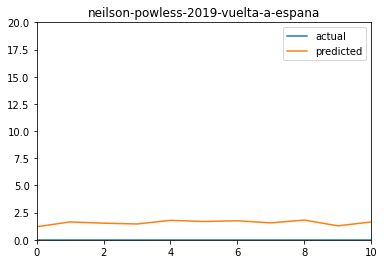

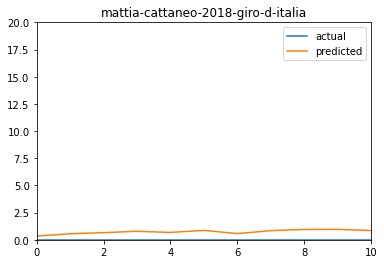

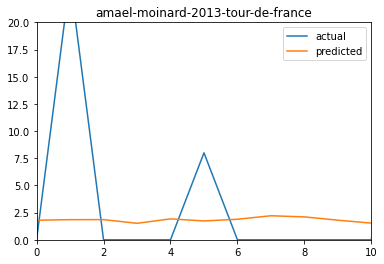

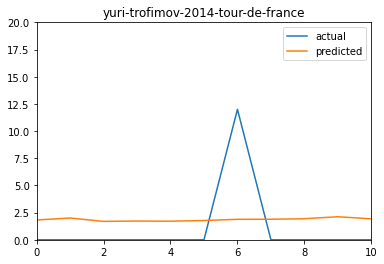

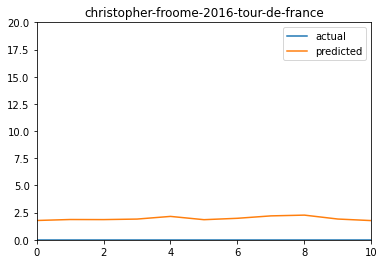

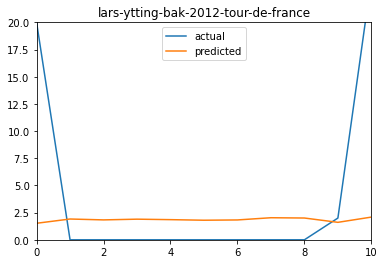

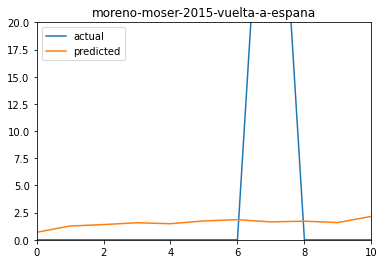

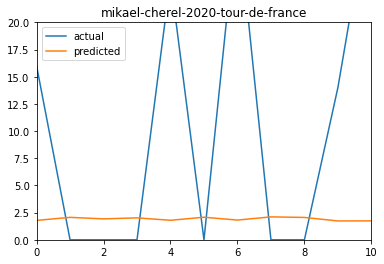

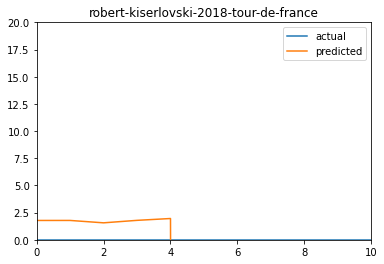

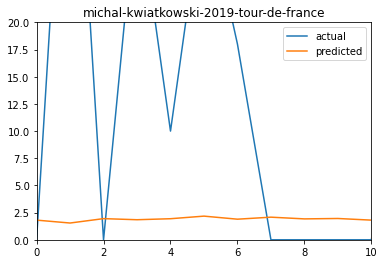

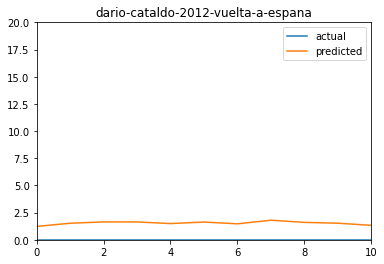

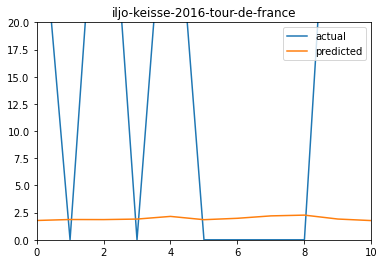

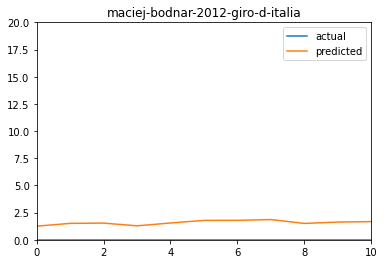

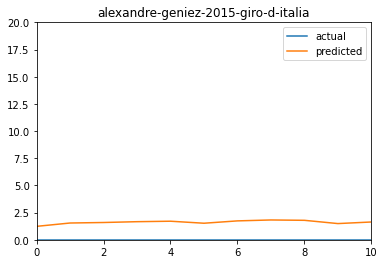

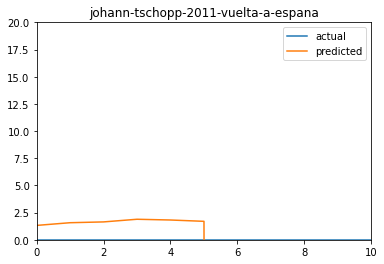

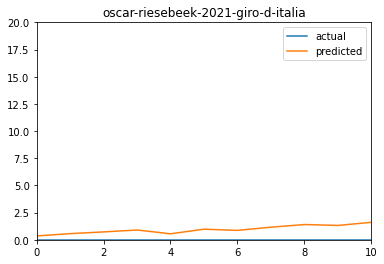

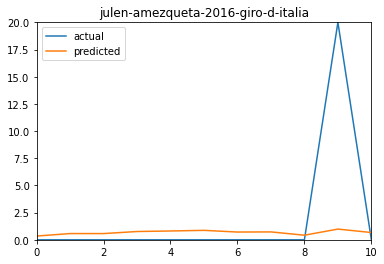

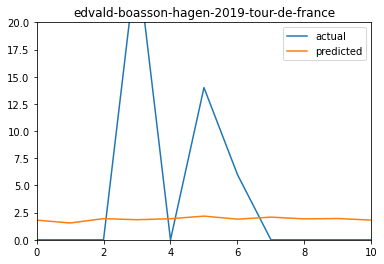

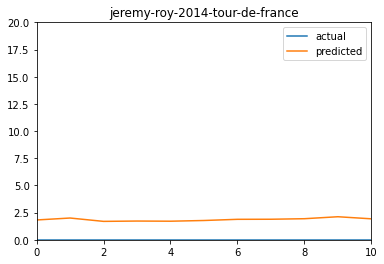

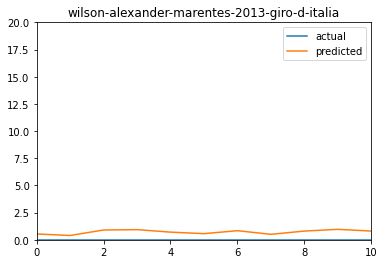

In [682]:
# extract the last predicted sequence
for seq in range(20,40):

    y_true = y[seq, :][-21:]
    y_pred = model.predict([X_encoder_test, X_decoder_test])[seq, :][-21:]

    # plot the last predicted sequence
    plt.title(list(test_name)[seq])
    plt.plot(y_true.flatten(), label='actual')
    plt.plot(y_pred.flatten(), label='predicted')
    plt.axis([0, 10, 0, 20])
    plt.legend()
    plt.show()

In [513]:
shuffled = np.arange(0,101,1)
np.random.shuffle(shuffled)
shuffled

array([ 95,  17,   2,  60,  28,  39,   0,  47,  52,   4,  26,  33,  58,
        67,  83,  63,  75,  88,  64,  71,  41,  84,  46,  44,  74,  59,
        65,  90,  53,   7,  80,  81,  15,  55,  89,  76,  77,  98,  22,
         1,  73,   5,  14,  78,  11,  43,  27,   3,  72,  86,  31,  61,
        16,  25,  85,  87,  19,  82,  48,  45,  35,  66,  50,  34,  10,
        62,  13,   6,  93,  79,  18,  40,  96,  92,  97,  30,  37,  57,
        51,  23, 100,  94,  42,  24,  56,  21,  32,  49,   9,  29,  36,
        20,  70,  99,  38,  91,  12,   8,  54,  68,  69])

In [373]:
X = torch.load('torch_data/X_full_scaled.pt')
y = torch.load('torch_data/y_full_scaled.pt')

In [374]:
X_tour = torch.load('torch_data/X_tour.pt')
y_tour = torch.load('torch_data/y_tour.pt')

In [418]:
X_tdf = torch.load('torch_data/X_tdf_2022.pt')
y_tdf = torch.load('torch_data/y_tdf_2022.pt')

X_tdf_tour = torch.load('torch_data/X_tour_tdf_2022.pt')
y_tdf_tour = torch.load('torch_data/y_tour_tdf_2022.pt')

In [417]:
y_tdf[0].shape

(62, 60)

In [428]:
X_tdf.shape, y_tdf.shape, X_tdf_tour.shape, y_tdf_tour.shape

((2210, 80, 4), (2210, 80, 1), (2210, 80, 4), (2210, 80, 1))

In [383]:
X_tour_pad = []
y_tour_pad = []

for xx in X_tour:
    X_tour_pad.append(pad_sequences(xx, maxlen=80, dtype='float', padding='pre', value=-1000.).T)
    
for yy in y_tour:
    y_tour_pad.append(pad_sequences(yy, maxlen=80, dtype='float', padding='pre', value=-1000.).T)
    
X_tour_pad = np.array(X_tour_pad)
y_tour_pad = np.array(y_tour_pad)

In [384]:
X_tour_pad.shape, y_tour_pad.shape

((38304, 80, 4), (38304, 80, 1))

In [385]:
X.shape, y.shape

((38304, 80, 4), (38304, 21, 1))

In [378]:
train_data_merged = []

for xx, yy in zip(X, y):
    train_data_merged.append(np.concatenate((xx, yy), axis=1))
    
train_data_merged = np.array(train_data_merged)

train_data_merged.shape

(38304, 80, 5)

In [429]:
train_data_merged_pred = []

for xx, yy in zip(X_tdf, y_tdf):
    train_data_merged_pred.append(np.concatenate((xx, yy), axis=1))
    
train_data_merged_pred = np.array(train_data_merged_pred)

train_data_merged_pred.shape

(2210, 80, 5)

In [358]:
# train the model
from tensorflow.keras.callbacks import EarlyStopping
metric = metrics.MAE

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

In [426]:
X_encoder = train_data_merged  # past features and target values
X_decoder = X_tour_pad  # future features values
y = y_tour_pad          # future target values

X_encoder.shape, X_decoder.shape, y.shape

((38304, 80, 5), (38304, 80, 4), (38304, 80, 1))

In [430]:
X_encoder_pred = train_data_merged_pred  # past features and target values
X_decoder_pred = X_tdf_tour  # future features values
y_pred = y_tdf_tour

X_encoder_pred.shape, X_decoder_pred.shape, y_pred.shape

((2210, 80, 5), (2210, 80, 4), (2210, 80, 1))

In [459]:
X_tdf_tour[0][-21:]

array([[-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [ 4.01315789e-02,  3.79506641e-03,  3.02637268e-03,
         8.55408389e-01],
       [ 6.61842105e-01,  0.00000000e+00,  1.65585819e-01,
         8.55408389e-01],
       [ 5.95394737e-01,  9.48766603e-03,  1.84464620e-01,
         8.55408389e-01],
       [ 5.60855263e-01,  9.86717268e-02,  2.57241677e-01,
      

In [387]:
# define the encoder and decoder
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    y = LSTM(units=100, return_sequences=True)(y)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

In [389]:
# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

In [394]:
# train the model
from tensorflow.keras.callbacks import EarlyStopping
metric = metrics.MAE

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/100
210/210 [==============================] - 19s 77ms/step - loss: 44.6760 - mean_absolute_error: 3.1075 - val_loss: 23.3128 - val_mean_absolute_error: 1.7873
Epoch 2/100
210/210 [==============================] - 15s 73ms/step - loss: 18.5712 - mean_absolute_error: 1.4276 - val_loss: 19.5045 - val_mean_absolute_error: 1.3631
Epoch 3/100
210/210 [==============================] - 15s 73ms/step - loss: 17.1064 - mean_absolute_error: 1.3262 - val_loss: 18.8654 - val_mean_absolute_error: 1.6384
Epoch 4/100
210/210 [==============================] - 15s 73ms/step - loss: 16.4553 - mean_absolute_error: 1.3535 - val_loss: 18.1419 - val_mean_absolute_error: 1.3189
Epoch 5/100
210/210 [==============================] - 15s 73ms/step - loss: 15.9128 - mean_absolute_error: 1.3751 - val_loss: 17.7999 - val_mean_absolute_error: 1.3541
Epoch 6/100
210/210 [==============================] - 15s 73ms/step - loss: 18.0648 - mean_absolute_error: 1.7998 - val_loss: 22.1699 - val_mean_absolute_

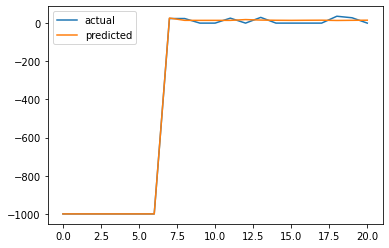

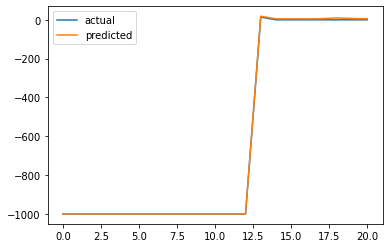

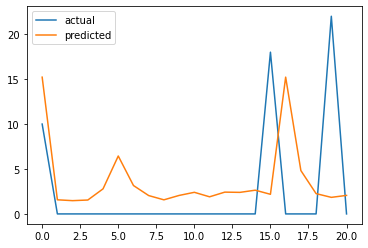

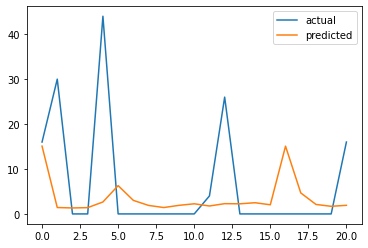

In [408]:
# extract the last predicted sequence
for seq in [-24, -36, -87, -103]:

    y_true = y[seq, :][-21:]
    y_pred = model.predict([X_encoder, X_decoder])[seq, :][-21:]

    # plot the last predicted sequence
    plt.plot(y_true.flatten(), label='actual')
    plt.plot(y_pred.flatten(), label='predicted')
    plt.legend()
    plt.show()

In [431]:
y_pred = model.predict([X_encoder_pred, X_decoder_pred])

In [498]:
y_pred[141][-21:]

array([[-999.9335   ],
       [-999.9538   ],
       [-999.9408   ],
       [-999.95404  ],
       [-999.95416  ],
       [-999.9541   ],
       [-999.9541   ],
       [-999.9541   ],
       [  -2.3633783],
       [  -2.4015312],
       [  -2.40442  ],
       [  -2.4071722],
       [  -2.3799295],
       [  -2.4229388],
       [  -2.3871193],
       [  -2.424222 ],
       [  -2.4134839],
       [  -2.41201  ],
       [  -2.3719888],
       [  -2.3917294],
       [  -2.4107258]], dtype=float32)

In [403]:
y[-1, :][-22:]

array([[-1000.],
       [   18.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.]])

In [205]:
X2 = []
y2 = []

for xx, yy in zip(X,y):
    X2.append(xx.T)
    y2.append(yy.T)
    
X2 = np.array(X2)
y2 = np.array(y2)

print(X2.shape)
print(y2.shape)

(36268, 60, 4)
(36268, 60, 1)


In [206]:
X_train, X_test = X2[:29014], X2[29014:]
y_train, y_test = y2[:29014], y2[29014:]

In [207]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [216]:
def init_model():
    metric = metrics.MAE
    opt = optimizers.RMSprop(learning_rate=0.01)
    
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(layers.Masking(mask_value=-1000., input_shape=(60,4)))
    #model.add(normalizer)
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse',
                  optimizer=opt,
                  metrics = [metric])
    
    return model

In [217]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_26 (Masking)        (None, 60, 4)             0         
                                                                 
 normalization_22 (Normaliza  (None, 60, 4)            9         
 tion)                                                           
                                                                 
 lstm_45 (LSTM)              (None, 60, 20)            2000      
                                                                 
 lstm_46 (LSTM)              (None, 60, 10)            1240      
                                                                 
 dense_55 (Dense)            (None, 60, 50)            550       
                                                                 
 dense_56 (Dense)            (None, 60, 10)            510       
                                                     

In [218]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model = init_model()

history = model.fit(X_train, y_train, epochs=3, validation_split=0.2, 
            batch_size=64,
            callbacks=[es], verbose=2)

Epoch 1/3
363/363 - 12s - loss: 24119.9844 - mean_absolute_error: 45.2602 - val_loss: 162.1123 - val_mean_absolute_error: 9.7059 - 12s/epoch - 34ms/step
Epoch 2/3
363/363 - 9s - loss: 1105.1848 - mean_absolute_error: 11.4878 - val_loss: 181.4655 - val_mean_absolute_error: 11.2093 - 9s/epoch - 24ms/step
Epoch 3/3
Restoring model weights from the end of the best epoch: 1.
363/363 - 9s - loss: 1166.8269 - mean_absolute_error: 10.8595 - val_loss: 434.6733 - val_mean_absolute_error: 16.4256 - 9s/epoch - 24ms/step
Epoch 3: early stopping


In [219]:
model.evaluate(X_test, y_test)

227/227 [==============================] - 1s 6ms/step - loss: 172.1444 - mean_absolute_error: 10.3812


[172.14443969726562, 10.381194114685059]

In [220]:
prediction = model.predict(X_test)

In [224]:
y_test[0]

array([[    2.],
       [   24.],
       [   16.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [   24.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [   20.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.

In [223]:
prediction[0]

array([[   1.637166 ],
       [   2.5607803],
       [   2.8002381],
       [   2.861462 ],
       [   2.9029677],
       [   2.926814 ],
       [   2.9526014],
       [   3.0281916],
       [   3.0470035],
       [   3.1738315],
       [   3.2406805],
       [   3.163703 ],
       [   3.122875 ],
       [   3.1297417],
       [   3.0497375],
       [   3.0244846],
       [   3.014164 ],
       [   3.0789998],
       [   3.0488122],
       [   3.0417457],
       [   3.0359643],
       [   3.3961957],
       [   3.5793905],
       [   3.276527 ],
       [   3.377349 ],
       [   3.4301891],
       [   3.6137505],
       [   3.259481 ],
       [-959.6419   ],
       [-986.57965  ],
       [-986.2376   ],
       [-983.0091   ],
       [-982.3925   ],
       [-984.5135   ],
       [-985.385    ],
       [-985.9052   ],
       [-986.1657   ],
       [-986.3189   ],
       [-986.419    ],
       [-986.4943   ],
       [-986.5567   ],
       [-986.6114   ],
       [-986.6608   ],
       [-98

In [49]:
history.history

{'loss': [34356968.0,
  24494996.0,
  16713496.0,
  15075442.0,
  15033100.0,
  15030301.0,
  15029687.0,
  15029394.0,
  15029253.0,
  15029116.0,
  15029027.0,
  15028953.0,
  15028918.0,
  15028885.0,
  15028829.0,
  15028805.0,
  15028790.0],
 'mean_squared_error': [34356968.0,
  24494996.0,
  16713496.0,
  15075442.0,
  15033100.0,
  15030301.0,
  15029687.0,
  15029394.0,
  15029253.0,
  15029116.0,
  15029027.0,
  15028953.0,
  15028918.0,
  15028885.0,
  15028829.0,
  15028805.0,
  15028790.0],
 'val_loss': [45338640.0,
  26658382.0,
  17907072.0,
  17456198.0,
  17448940.0,
  17440516.0,
  17439674.0,
  17450650.0,
  17441042.0,
  17441914.0,
  17440762.0,
  17439960.0,
  17440532.0,
  17440828.0,
  17439944.0,
  17439718.0,
  17440314.0],
 'val_mean_squared_error': [45338640.0,
  26658382.0,
  17907072.0,
  17456198.0,
  17448940.0,
  17440516.0,
  17439674.0,
  17450650.0,
  17441042.0,
  17441914.0,
  17440762.0,
  17439960.0,
  17440532.0,
  17440828.0,
  17439944.0,
  174

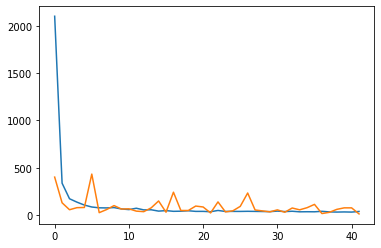

In [169]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [51]:
df = pd.read_csv('merged_treated.csv', index_col=[0])
df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,distance,points,Avg. speed winner:,Distance:,Parcours type:,ProfileScore:,Vert. meters:,Startlist quality score:,Won how:,adjusted_points
0,egan-bernal,2020,etappe,2020-09-16,0,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,20.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,14962800.0
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
4,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0


In [56]:
for i in df.name.unique()[:2]:
    print(i)

egan-bernal
andrey-amador


In [57]:
ls = []

for rider in df.name.unique()[:2]:
    ls.append(df_small[df_small['name']==rider])

In [ ]:
import numpy as np

def subsample_sequence(df, length):
        df_small[df_small['name']==rider]
        # $CHALLENGIFY_BEGIN
        last_possible = df.shape[0] - length - 5
        
        random_start = np.random.randint(0, last_possible)
        X = df[random_start: random_start+length].values
        y = df.iloc[random_start+length+1:random_start+length+21]['points']
        # $CHALLENGIFY_END
        return X, y

for rider in ls:
    X, y = subsample_sequence(rider, 365)

/var/folders/3l/70h6qcrd72q0j5x4sscw7qn40000gn/T/ipykernel_9756/69888416.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_small[df_small['name']==rider]


: 

: 

In [ ]:
X

array([[13.8, 0.0, 13.0, 28.0, 1812, 'daniele-bennati'],
       [13.8, 0.0, 13.0, 28.0, 1812, 'roman-kreuziger'],
       [13.8, 0.0, 13.0, 28.0, 1812, 'rafal-majka'],
       ...,
       [155.0, 0.0, 323.0, 4282.0, 1073, 'marcel-wyss'],
       [155.0, 0.0, 323.0, 4282.0, 1073, 'dominik-nerz'],
       [155.0, 0.0, 323.0, 4282.0, 1073, 'jan-barta']], dtype=object)